In [2]:
import pandas as pd
from urllib.request import urlretrieve
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [3]:
raw_df =pd.read_csv('./dataset/weatherAUS.csv')

In [4]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

<Axes: title={'center': 'No/ of Rows per Year'}, xlabel='Date', ylabel='count'>

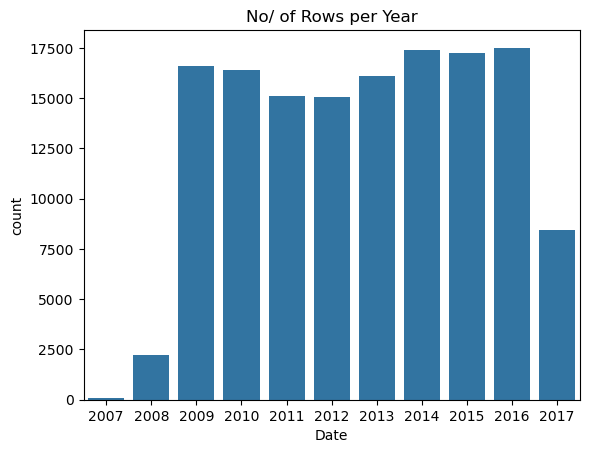

In [7]:
plt.title("No/ of Rows per Year")
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

In [8]:
year = pd.to_datetime(raw_df.Date).dt.year


train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [9]:
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)
print('test_df.shape:', test_df.shape)

train_df.shape: (98988, 23)
val_df.shape: (17231, 23)
test_df.shape: (25974, 23)


In [10]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [11]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [12]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [13]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [14]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Imputing missing numeric values

In [15]:
train_inputs[numeric_cols].isna().sum()

MinTemp            434
MaxTemp            198
Rainfall          1000
Evaporation      37110
Sunshine         40696
WindGustSpeed     6902
WindSpeed9am      1133
WindSpeed3pm      1140
Humidity9am       1265
Humidity3pm       1186
Pressure9am       9345
Pressure3pm       9309
Cloud9am         35764
Cloud3pm         36766
Temp9am            783
Temp3pm            663
dtype: int64

In [16]:
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scaling Numeric Features

In [18]:
train_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,-8.5,-4.1,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,980.5,979.0,0.0,0.0,-5.9,-5.1
max,33.9,48.1,371.0,82.4,14.3,135.0,87.0,87.0,100.0,100.0,1041.0,1039.6,9.0,9.0,40.2,46.1


In [19]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [20]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [21]:
train_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.013233,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0304,0.0,0.0,0.027426,0.005758
max,1.0,1.000000,1.0,0.568276,0.986207,1.0,0.669231,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.000000,0.988484


# Encoding Categorical Data


In [22]:
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [23]:
train_df[categorical_cols].isna().sum()

Location          0
WindGustDir    6943
WindDir9am     7323
WindDir3pm     2030
RainToday      1000
dtype: int64

In [24]:
train_inputs[categorical_cols] = train_df[categorical_cols].fillna('unknown')
val_inputs[categorical_cols] = val_df[categorical_cols].fillna('unknown')
test_inputs[categorical_cols] = test_df[categorical_cols].fillna('unknown')

In [25]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])

In [26]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))


In [27]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/tmp/ipykernel_5602/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipykernel_5602/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/tmp/ipykernel_5602/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

In [28]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Training

In [29]:
model = DecisionTreeClassifier(random_state=42)

In [30]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

# Evaluation


In [31]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unknown,RainToday_No,RainToday_Yes,RainToday_unknown
0,0.516509,0.523629,0.001617,0.037723,0.525852,0.294574,0.153846,0.275862,0.71,0.22,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.375000,0.565217,0.000000,0.037723,0.525852,0.294574,0.030769,0.252874,0.44,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.504717,0.576560,0.000000,0.037723,0.525852,0.310078,0.146154,0.298851,0.38,0.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.417453,0.620038,0.000000,0.037723,0.525852,0.139535,0.084615,0.103448,0.45,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.613208,0.701323,0.002695,0.037723,0.525852,0.271318,0.053846,0.229885,0.82,0.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144548,0.599057,0.718336,0.000000,0.037723,0.525852,0.286822,0.184615,0.298851,0.22,0.13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144549,0.556604,0.786389,0.000000,0.037723,0.525852,0.193798,0.146154,0.229885,0.16,0.08,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144550,0.608491,0.805293,0.000000,0.037723,0.525852,0.255814,0.200000,0.103448,0.15,0.08,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
144551,0.674528,0.818526,0.000000,0.037723,0.525852,0.286822,0.215385,0.195402,0.22,0.09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
train_preds = model.predict(X_train)

In [33]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [34]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 98988, dtype: object

In [35]:
train_probs = model.predict_proba(X_train)

In [36]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [37]:
accuracy_score(train_preds, train_targets)

0.9999797955307714

the training set accuracy is close to 100% But we can't rely solely on the training set accuracy, we must evaluate the model on the validatation set too.

We can make predictions and compute accuracy in one step using modl.score

In [38]:
model.score(X_val, val_targets)

0.7921188555510418

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No"

In [39]:
val_targets.value_counts() / len(val_targets)

RainTomorrow
No     0.788289
Yes    0.211711
Name: count, dtype: float64

it appears that the model has learned the trianing examples perfect, and does not generalize well on previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any ml project

# Visualizatoion
We can visualize the decistion tree learned from the training data.

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.01\ngini = 0.316\nsamples = 7434\nvalue = [1462, 5972]'),
 Text(0.8125, 0.125,

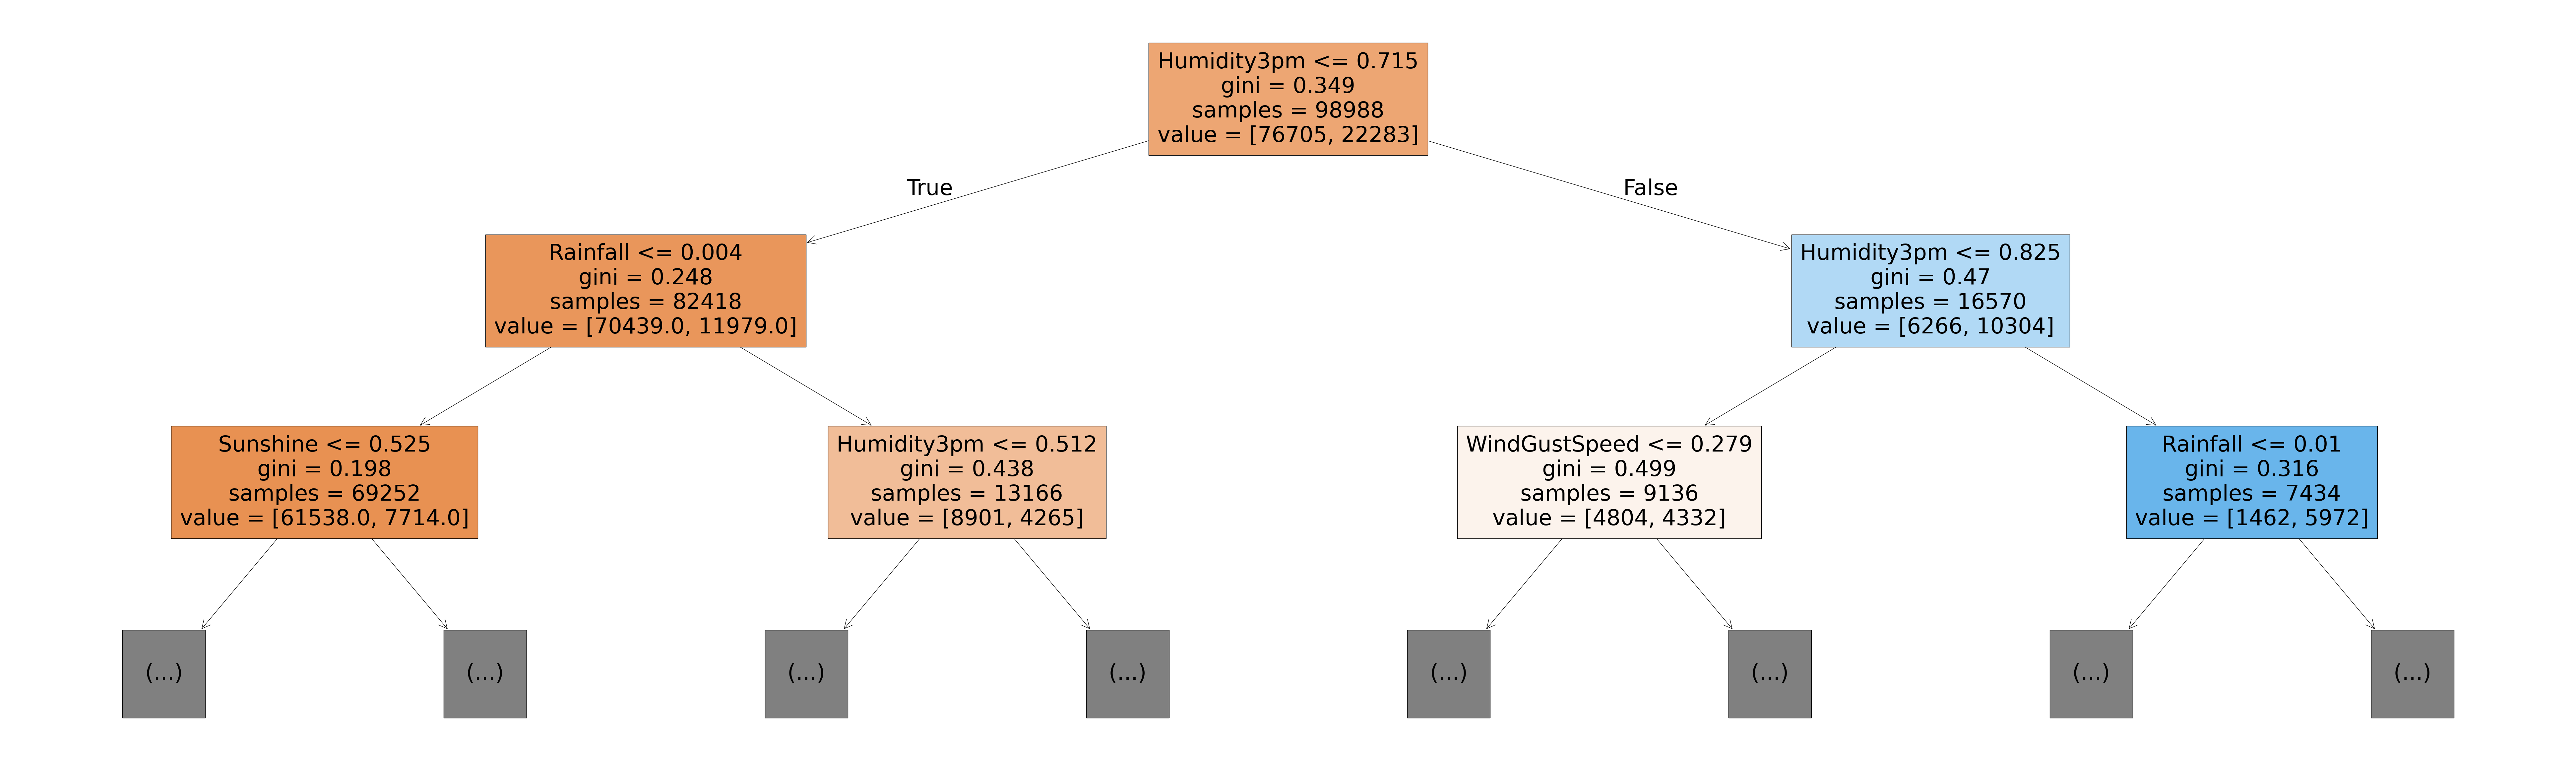

In [40]:
plt.figure(figsize=(100,30))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

How a Decisition tree is created

Note the gini value in each box. This is the loss function used by the decision tree to decide which cloumn should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect splut(only one class on each side) has a Gini index of 0.

In [41]:
model.tree_.max_depth

48

we can also display the tree as text, which can be easier to follow for deeper trees

In [42]:
tree_text = export_text(model, max_depth=10, feature_names=(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

# Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results by a decision tree.

In [43]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_unknown',
       'RainToday_No', 'RainToday_Yes', 'RainToday_unknown'],
      dtype='object', length=119)

In [44]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

let's turn this into a dataframe and visualize the most important features

In [45]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [46]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

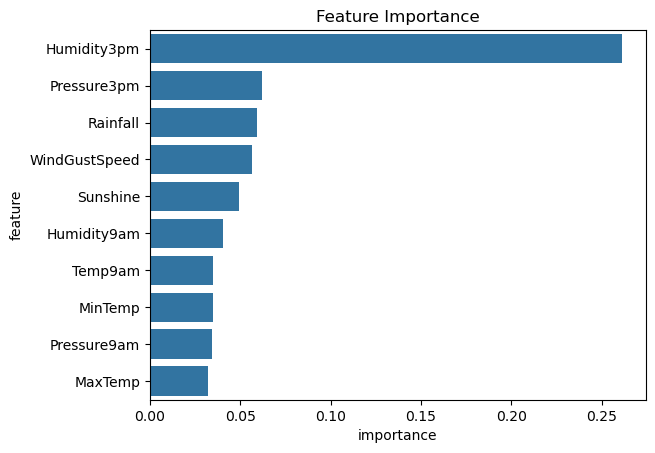

In [167]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

# Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularization

The decisionTreeClassifier accepts several arguments, some of which can be modified to reduce overfiting.

In [47]:
DecisionTreeClassifier

sklearn.tree._classes.DecisionTreeClassifier

these arguments are called hyperparameters because must be configured manually(as opposed to the parameters within the model which are learned from the data. We'll explore a couple of hyperparameters:)

max_depth

max_leaf_nodes

max_depth

By reducing the maximum depth of the decision tree, we can prevent the tree memorizing all training examples, which may lead to better generalization

In [48]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [49]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

we can compute the accuracy of the model on the training and validation sets using model.score

In [50]:
model.score(X_train, train_targets)

0.8291308037337859

In [51]:
model.score(X_val, val_targets)

0.8334397307178921

In [52]:
model.classes_

array(['No', 'Yes'], dtype=object)

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]\nclass = No'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]\nclass = No'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.363\nsamples = 12620\nvalue = [9618, 3002]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.153\nsamples = 56632\nvalue = [51920, 4712]\nclass = No'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]\nclass = No'),
 Text(0.3125, 0.125, 'gini = 0.293\nsamples = 4299\nvalue = [3531, 768]\nclass = No'),
 Text(0.4375, 0.125, 'gini = 0.478\nsamples = 8867\nvalue = [5370, 3497]\nclass = No'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]\nclass = Yes'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'WindGustSp

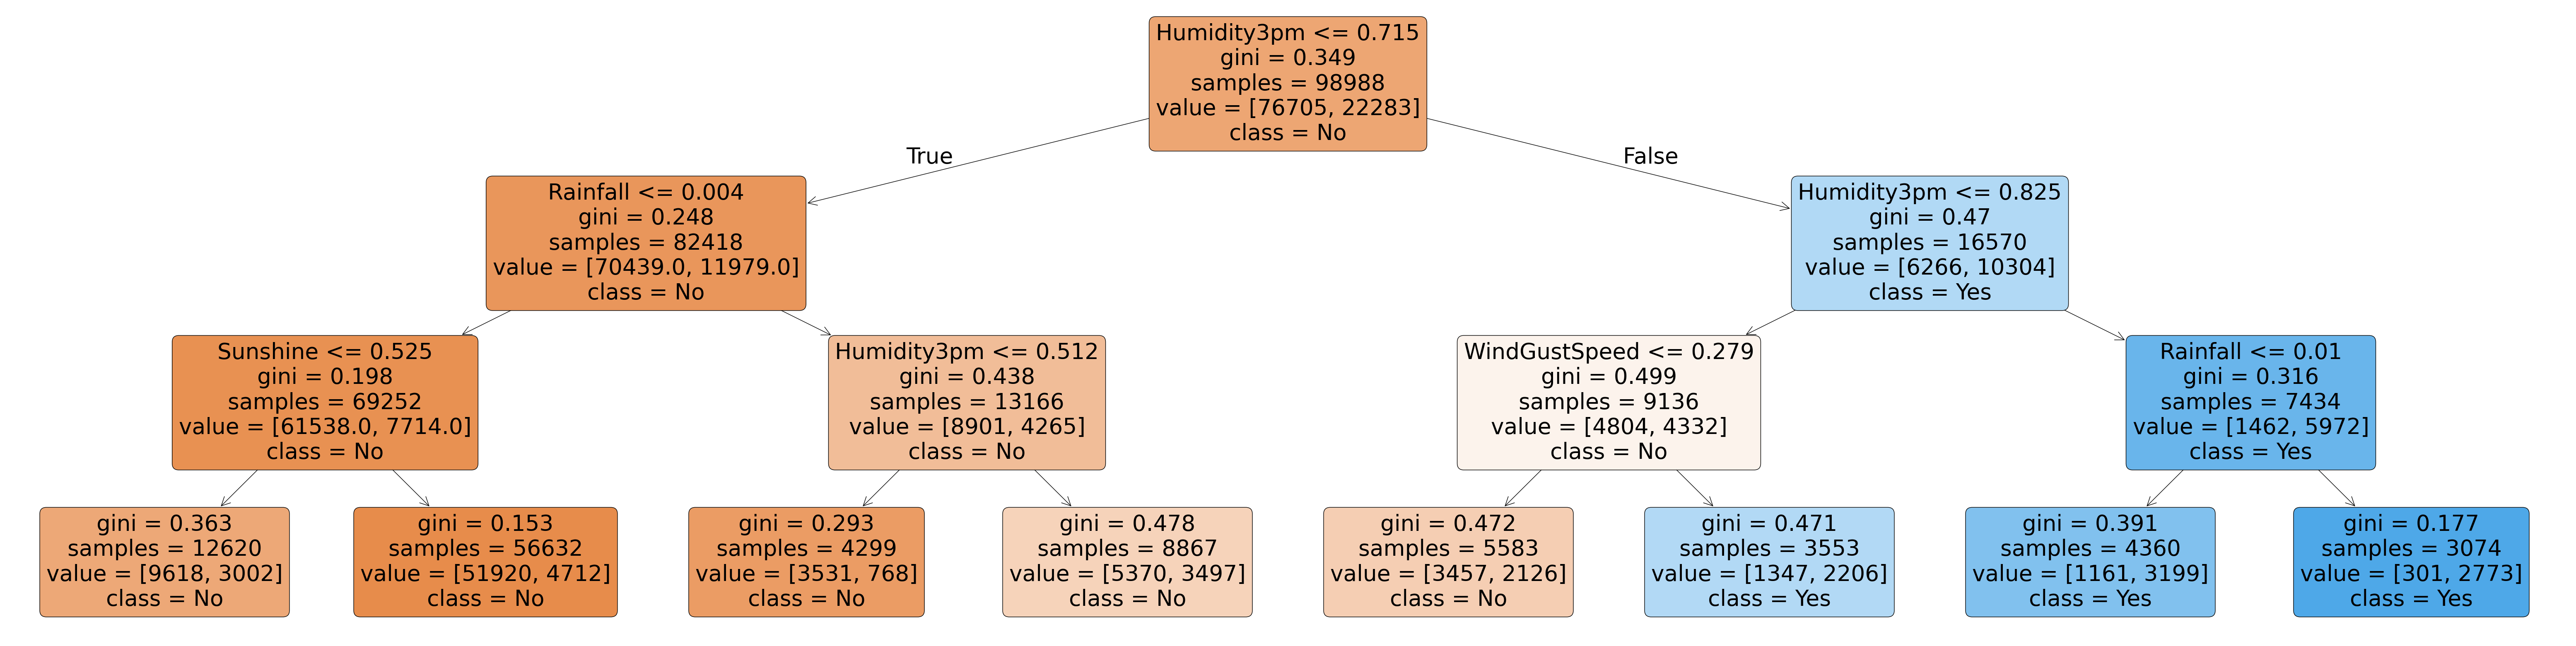

In [53]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_)

let's experiment with different depths using a helper function

In [54]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error':train_acc, "Validation error":val_acc}

In [55]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])

In [56]:
errors_df

,Max Depth,Training Error,Validation error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


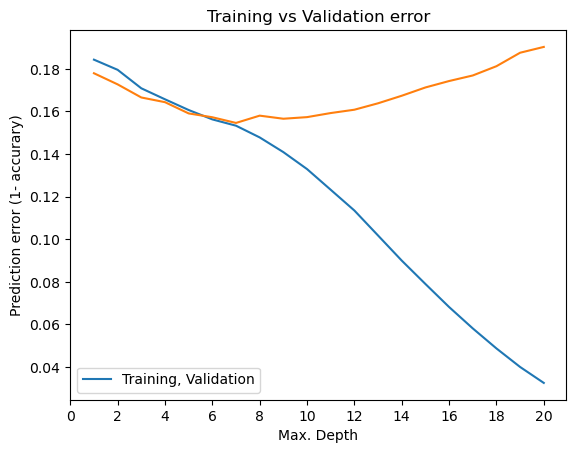

In [57]:
plt.Figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation error']) 
plt.title("Training vs Validation error")
plt.xticks(range(0, 21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction error (1- accurary)')
plt.legend(['Training, Validation'])

You'll often need to tune hyperparameters carefully to find the optimal fit. in the above case, it appearss that a maximun depth of 7 results in the lowest validation error.

In [58]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8453949277465034

max_leaf_nodes

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths

In [59]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [60]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [61]:
model.score(X_train, train_targets)

0.8480421869317493

In [62]:
model.score(X_val, val_targets)

0.8442342290058615

In [63]:
model.tree_.max_depth

12

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [64]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

# Training random forest

while tuning the pypherparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model.

The key idea here is that each decision tree in the forest wiil make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of thee crowd"

In [65]:
model = RandomForestClassifier(n_jobs=1, random_state=42)

n_jobs allows the random forest to use multiple parallel workers to train decision trees, and random_state=32 ensures that the we get the same results for each execution

In [66]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_jobs=1, random_state=42)

In [67]:
model.score(X_train, train_targets)

0.9999494888269285

In [68]:
model.score(X_val, val_targets)

0.8566537055307295

Once again, the training accuracy is almost100%, but this time the validation accuracy is much better. in fact, it is better than the bset single decision tree we had trained so far. Do you see the power of random forest>

This general technique of combining the results of many models is called ""ensembling", it works because most errors of individual model cancel out on averaging

we can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [69]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

we can access individual decision tree using model.estimators_

In [70]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

[Text(0.5, 0.875, 'Sunshine <= 0.403\ngini = 0.347\nsamples = 62607\nvalue = [76887, 22101]'),
 Text(0.25, 0.625, 'Pressure9am <= 0.609\ngini = 0.499\nsamples = 11288\nvalue = [9272, 8542]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Cloud9am <= 0.833\ngini = 0.475\nsamples = 6067\nvalue = [3702, 5808]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'WindGustDir_NNE <= 0.5\ngini = 0.442\nsamples = 5221\nvalue = [5570.0, 2734.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'RainToday_Yes <= 0.5\ngini = 0.278\nsamples = 51319\nvalue = [67615, 13559]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Pressure9am <= 0.521\ngini = 0.207\nsamples = 41960\nvalue = [58514.0, 7796.0]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Pressure9am <= 0.614\ngini = 0.475\nsamples = 9359\nvalue = [9101, 5763]'),
 Text(0.8125, 0.1

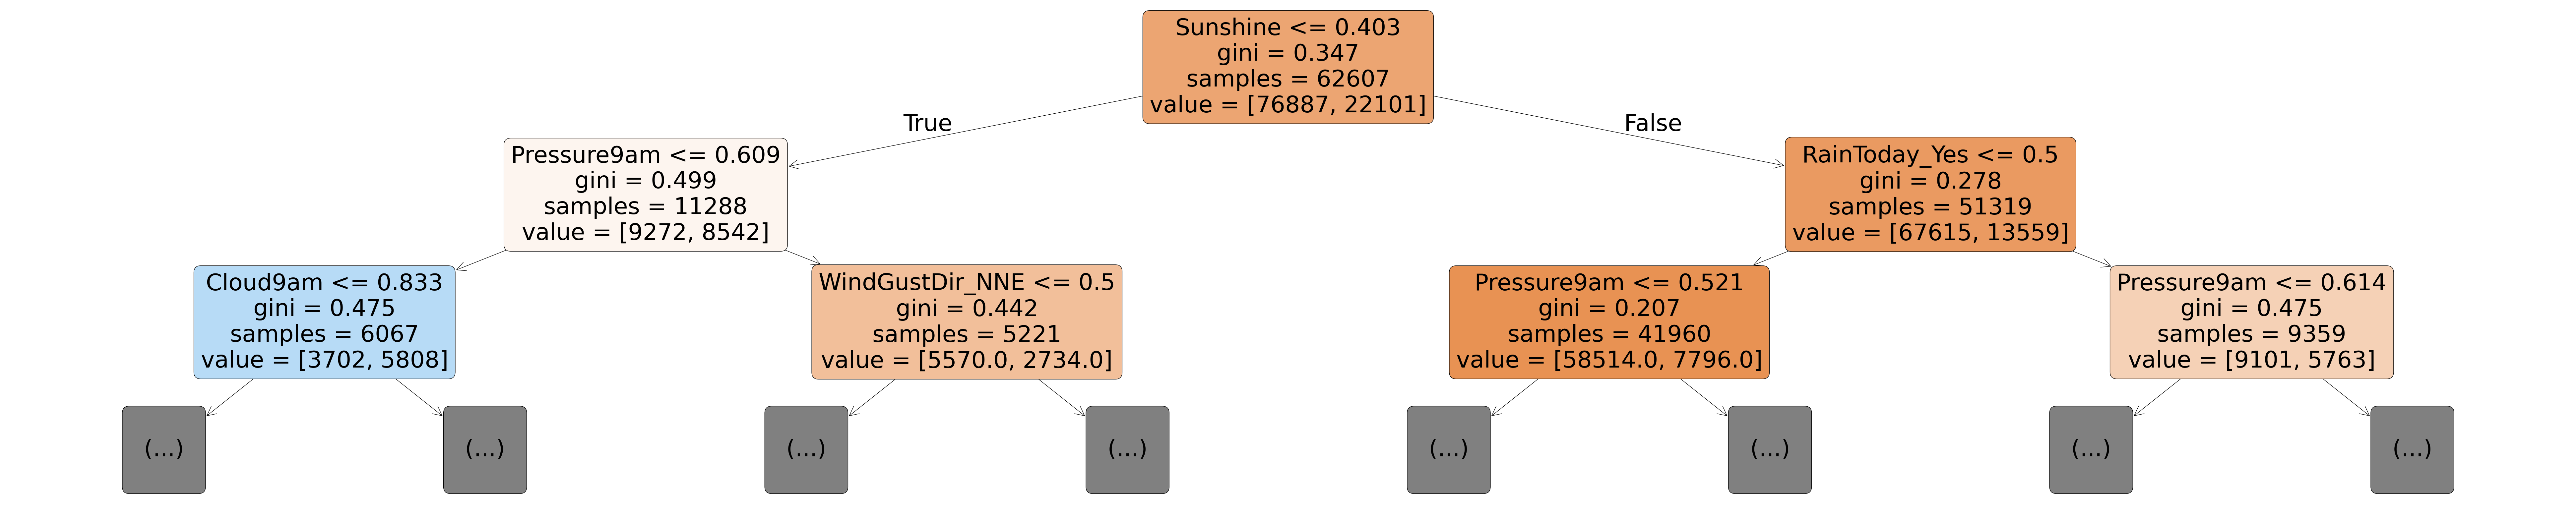

In [71]:
plt.figure(figsize=(100,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True)

[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\ngini = 0.349\nsamples = 62610\nvalue = [76714, 22274]'),
 Text(0.25, 0.625, 'WindGustDir_ESE <= 0.5\ngini = 0.262\nsamples = 48715\nvalue = [65024, 11930]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Pressure3pm <= 0.505\ngini = 0.267\nsamples = 46043\nvalue = [61211.0, 11515.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.665\ngini = 0.177\nsamples = 2672\nvalue = [3813, 415]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'WindSpeed3pm <= 0.333\ngini = 0.498\nsamples = 13895\nvalue = [11690, 10344]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Sunshine <= 0.534\ngini = 0.495\nsamples = 11567\nvalue = [10070, 8283]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Sunshine <= 0.424\ngini = 0.493\nsamples = 2328\nvalue = [1620, 2061]'),
 Text(0.8125, 0.

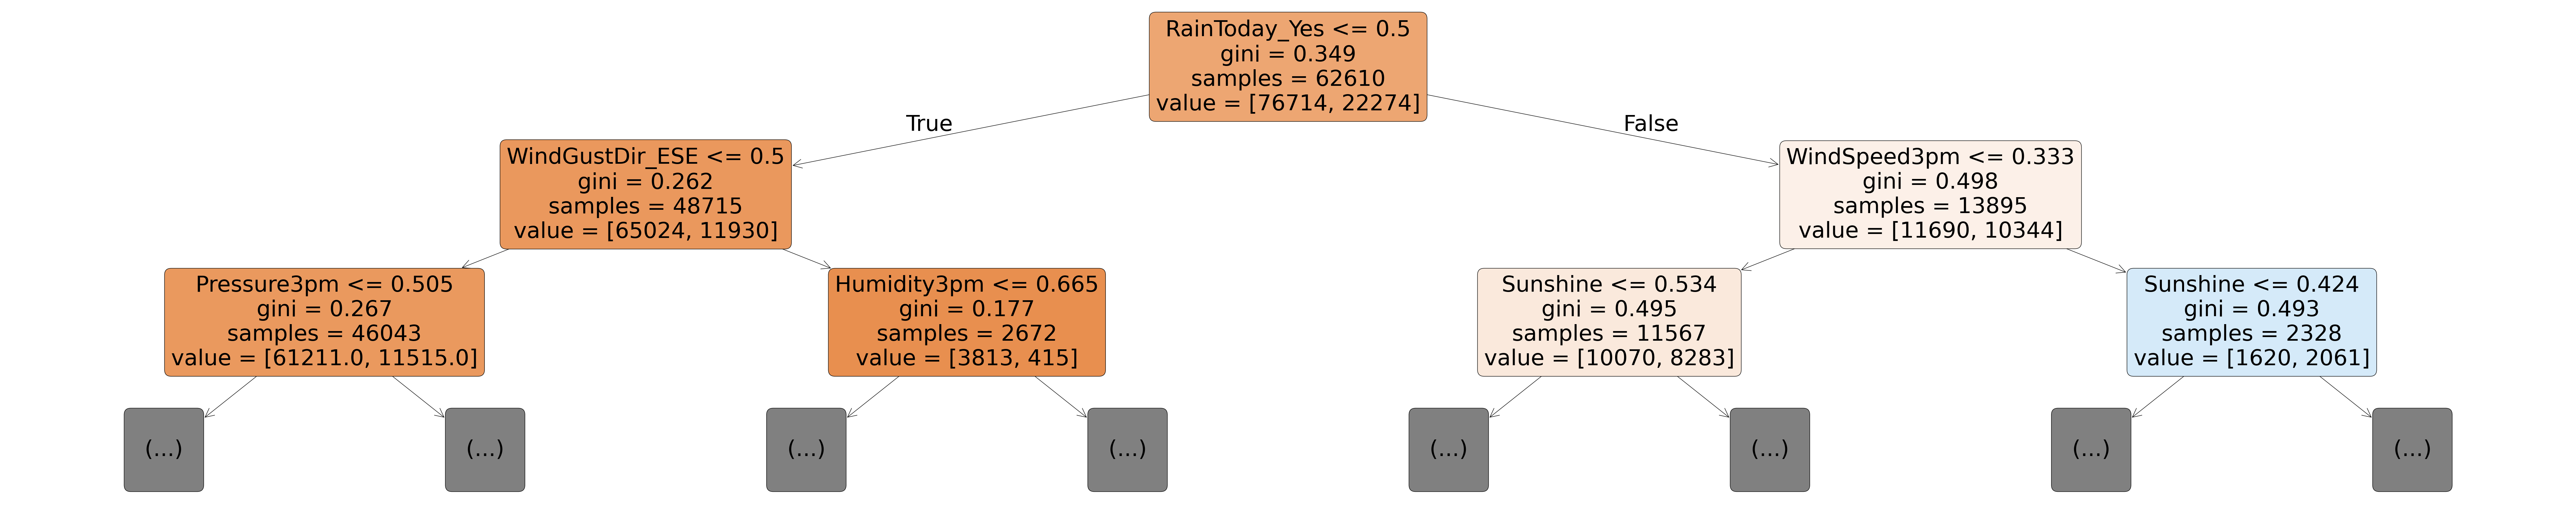

In [72]:
plt.figure(figsize=(100,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True)

just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [73]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [74]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

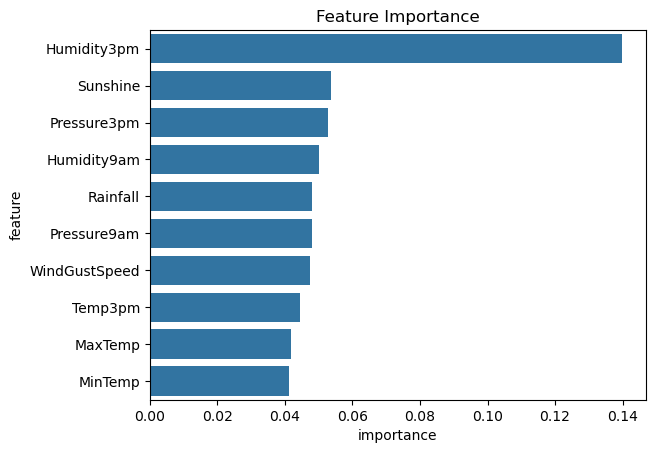

In [75]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

# hyperparameter tuning with random forest

In [76]:
RandomForestClassifier

sklearn.ensemble._forest.RandomForestClassifier

let's create a base model with which we can compare models with tuned hyperparameters

In [77]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [78]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [79]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999494888269285, 0.8566537055307295)

we can use this as a benchmark for hyperparameter tuning

n_estimators

This argument controls the number of decision trees in the random forest. The default value is 100. for larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed.

In [80]:
model = RandomForestClassifier(random_state=42, n_jobs=1, n_estimators=10)

In [81]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=1, random_state=42)

In [82]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.986958015112943, 0.8485868492832686)

In [83]:
base_accs

(0.9999494888269285, 0.8566537055307295)

500 estimators

In [84]:
model = RandomForestClassifier(random_state=42, n_jobs=1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=1, random_state=42)

In [85]:
model.score(X_train, train_targets)

0.9999797955307714

In [86]:
model.score(X_val, val_targets)

0.8577563693343393

In [87]:
base_accs

(0.9999494888269285, 0.8566537055307295)

max_depth and max_leaf_nodes
 
These arguments are passed directly to each decision treem and control the maximum depth and max. no leaf nodes of each tree respectively, By default, no maximum depth is specifie, which is why each tree has a training accuracy of 100%.
Tou can specify a max_depth to reduce overfitting. 

In [88]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [89]:
test_params(max_depth = 5)

(0.8197862367155615, 0.8240961058557251)

In [90]:
test_params(max_depth = 26)

(0.9814826039519942, 0.8572340549010504)

In [93]:
test_params(max_leaf_nodes =2**5)

(0.8314341132258456, 0.833904010214149)

In [92]:
test_params(max_leaf_nodes =2**20)

(0.9999595910615429, 0.8568278103418258)

In [94]:
base_accs

(0.9999494888269285, 0.8566537055307295)

max_features

instead of picking all features(columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

max_features:{"auto", "sqrt", "log2"}, int, or float, default="auto"
    The number of features to consider when looking for the best split:
    - if int, then consider max_features features at each split
    - if float, then max_features is a fraction and round(max_features * n_features) features are considered at each split
    - if "auto", then max_features=sqrt(n_features)
    - if "sqrt", max_features=sqrt(n_features) (same as "auto")
    - if "log2", then max_features=log2(n_feature)
    - if None, then max_features=n_features
Note: the search for a split does not stop until atleast one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features


In [95]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [96]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

In [97]:
test_params(max_features=6)

(0.9999595910615429, 0.8558992513493123)

In [98]:
base_accs

(0.9999494888269285, 0.8566537055307295)